In [2]:
import numpy as np


def generate_data(size, bounds, true_beta=1.):
    x_bounds, y_bounds = bounds
    x = np.random.uniform(*x_bounds, size)
    y = np.clip(np.random.normal(true_beta * x, scale=.02), *y_bounds)
    return np.stack((x, y), axis=1)


def bias(estimates, population_parameter):
    return (np.array(estimates) - population_parameter).mean()

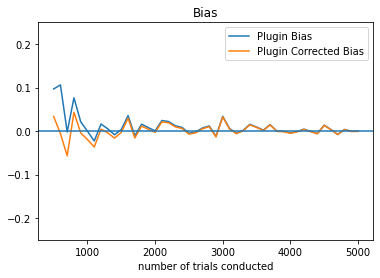

Text(0.5, 1.0, 'Standard deviation')

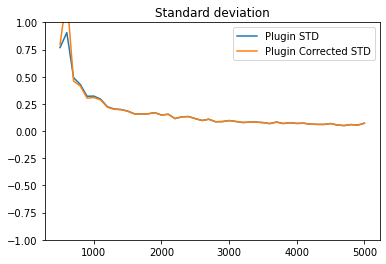

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
from post_fractional_estimate import debias_reciprocal
from stat_regression import release_sxx, release_sxy, _sens_sum


data_size = 500
data_bounds = [[-0.5, 0.5], [-1, 1]]
epsilon = 0.1
alpha = 0.66
true_beta = 1.
n_sims = 100
empirical_dist = np.random.laplace(size=10_000)

history = []
data_size_seq = np.arange(500, 5100, 100)
for data_size in data_size_seq:

    betas_plugin = []
    betas_plugin_corrected = []
    for _ in range(n_sims):
        data = generate_data(data_size, data_bounds, true_beta=true_beta)

        x_bounds, y_bounds = data_bounds
        sxy = release_sxy(data, data_bounds, epsilon * alpha)
        sxx = release_sxx(data[:, 0], x_bounds, epsilon * (1 - alpha))

        sxx_c = debias_reciprocal(
            sxx, _sens_sum(*x_bounds) ** 2 / (epsilon * (1 - alpha)),
            empirical_dist
        )

        betas_plugin.append(sxy / sxx)
        betas_plugin_corrected.append(sxy / sxx_c)

    
    history.append({
        "Plugin Bias": bias(betas_plugin, true_beta),
        "Plugin STD": np.std(betas_plugin),
        "Plugin Corrected Bias": bias(betas_plugin_corrected, true_beta),
        "Plugin Corrected STD": np.std(betas_plugin_corrected)
    })

history = pd.DataFrame(history, index=data_size_seq)

history.plot(y="Plugin Bias", ax=plt.gca())
history.plot(y="Plugin Corrected Bias", ax=plt.gca())
plt.axhline(0)
plt.title("Bias")
plt.ylim(-.25, .25)
plt.xlabel("number of trials conducted")
plt.show()

history.plot(y="Plugin STD", ax=plt.gca())
history.plot(y="Plugin Corrected STD", ax=plt.gca())
plt.ylim(-1, 1)
plt.title("Standard deviation")
